# Importing Libraries 

In [1]:
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import statsmodels.api as sm
import seaborn as sns 
import nltk as nlp
import string
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re

In [254]:
import warnings
sns.set(style="dark")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,7)})
pd.set_option('display.max_columns',500)

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

In [203]:
#importing quarterly data from seaworld 
income = pd.read_csv('seas_income_statement_quarter.csv',error_bad_lines=False)

b'Skipping line 6: expected 31 fields, saw 102\nSkipping line 7: expected 31 fields, saw 102\nSkipping line 15: expected 31 fields, saw 102\nSkipping line 16: expected 31 fields, saw 102\nSkipping line 20: expected 31 fields, saw 102\nSkipping line 21: expected 31 fields, saw 102\nSkipping line 30: expected 31 fields, saw 102\nSkipping line 31: expected 31 fields, saw 102\n'


# Scraping and downloading tripadvisor review data

<br> 

1) We used Selenium to scrape the reviews of about 1000 pages from the Orlando location 

2) A more detailed analysis would take into account reviews from various locations to remedy any issues in the reviews which are location dependent 

3) I feel justified in the data provided by the Orlando location as it's their largest and the one which had by far the greatest number of reviews 

4) We also imported the income statement of Seaworld to perform our revenue correlation analysis 


In [115]:
import csv
import time
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException

In [116]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/sam/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


In [117]:
driver.get("https://www.tripadvisor.com/Attraction_Review-g34515-d102412-Reviews-SeaWorld-Orlando_Florida.html")

In [118]:
# function to check if the button is on the page, to avoid miss-click problem
def check_exists_by_xpath(xpath):
    try:
        driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return False
    return True

In [119]:
# open the file to save the review
csvFile = open("reviews", 'a')
csvWriter = csv.writer(csvFile)

In [120]:
# change the value inside the range to save more or less reviews
for i in range(0,2000,6):
    
    if (check_exists_by_xpath("//span[@class='taLnk ulBlueLinks']")):
        # to expand the review 
        driver.find_element_by_xpath("//span[@class='taLnk ulBlueLinks']").click()
        time.sleep(5)
        
    container = driver.find_elements_by_xpath("//div[@class='Dq9MAugU T870kzTX LnVzGwUB']")
    num_page_items = len(container);
    
    for j in range(num_page_items):
        # to save the rating
        string = container[j].find_element_by_xpath(".//span[contains(@class, 'ui_bubble_rating bubble_')]").get_attribute("class") 
        data = string.split("_")
        #to save the date 
        #string2= container[j].find_element_by_xpath(".//*[@id='component_19']/div[3]/div/div[3]/div[2]/div[3]/div[2]/span").text
        try: 
            string2 = container[j].find_element_by_xpath(".//span[contains(@class, '_34Xs-BQm')]/.").text
            data2 = re.sub(r'.*:','',string2)
            data2 = data2.strip()
            csvWriter.writerow([data[3],data2, container[j].find_element_by_xpath(".//q[@class='IRsGHoPm']").text.replace("\n", "")])

        except NoSuchElementException: 
            continue 
        # to save in a csv file readable the star and the review [Ex: 50,"I love this place"]
        
    # to change the page
    if (check_exists_by_xpath('//a[@class="ui_button nav next primary "]')):
        driver.find_element_by_xpath('//a[@class="ui_button nav next primary "]').click()
    time.sleep(5)
    
driver.close()

# Data Cleaning and Overview 

<br> 

## Data Cleaning
<br>

Our initial data cleaning consisted of the following 


1) Cleaning up the dates: since our revenues will be in quarterly form I assigned each review a quarter based on the month and year it was in

2) Unfortunately, for time purposes the scrapes only went back to 2018 and so we are only able to observe the effects on the revenue for the years of 2020, 2019, and 2018 

3) We created a count_words feature which describes the length of each review; this will presumably have an effect on the sentiment of the review and so will be used as a predictive feature 


## Data Overview 

<br>
1) Our data consisted of 1653 reviews and we obtained 4 features; the rating given on a scale from 10-50 (50 being the highest), the review content, the length of the review, and the year and quarter the review took place

2) We also obtained the quarterly revenue for those years 

3) We had no missing values in the data 


In [129]:
#importing reviews 
rev = pd.read_csv('reviews', names = ['rating','date','review'])

In [177]:
#date feature cleaning 
def date_clean(df): 
    year = df['date'].apply(lambda x: re.findall('\d+',x)[0])
    month = df['date'].apply(lambda x: "".join(re.findall('[^\d+]',x)))
    month = month.str.strip()
    df['year'] = year 
    df['quarter'] = month
    return df

rev.loc[(rev.quarter == 'January') | (rev.quarter == 'February') |  (rev.quarter == 'April'),'quarter'] = 'q1'
rev.loc[(rev.quarter == 'April') | (rev.quarter == 'May') |  (rev.quarter == 'June'),'quarter'] = 'q2'
rev.loc[(rev.quarter == 'July') | (rev.quarter == 'August') |  (rev.quarter == 'September'),'quarter'] = 'q3'
rev.loc[(rev.quarter == 'October') | (rev.quarter == 'November') |  (rev.quarter == 'December'),'quarter'] = 'q4'

#cleaning income starement and retrieving dates and quarters 

x = income.columns.tolist()
x = [re.sub(r'\-\d\d\-\d\d\_',' ',y) for y in x]
income.columns =x 
revenue = income.iloc[0,:11]

revenue.drop(['date', 'Unnamed: 1'],inplace = True)

revenue.index = ['2020 q1', '2019 q4', '2019 q3', '2019 q2', '2019 q1', '2018 q4',
       '2018 q3', '2018 q2', '2018 q1']


#word count feature 
rev['word_count']= rev.review.apply(lambda x: len(x.split()))

#drop the date 
rev.drop('date',axis = 1,inplace = True)

In [247]:
#overview 
def quick(df): 
    print('Data Types:\n',df.dtypes)
    print('\nData Shape: \n',df.shape)
    print('\nOverall Info: \n', df.info())
    print('\nNull Values: \n', df.isna().sum())

In [251]:
quick(rev)

Data Types:
 rating         int64
review        object
quarter       object
year          object
word_count     int64
dtype: object

Data Shape: 
 (1653, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653 entries, 0 to 1652
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rating      1653 non-null   int64 
 1   review      1653 non-null   object
 2   quarter     1653 non-null   object
 3   year        1653 non-null   object
 4   word_count  1653 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 64.7+ KB

Overall Info: 
 None

Null Values: 
 rating        0
review        0
quarter       0
year          0
word_count    0
dtype: int64


# EDA 

<br>

## Overall Analysis 

<br> 

1) We began by visualizing the distribution of our ratings/sentiments; It seems that our classes are imbalanced where we have a greater number of 4 and 5 star ratings, because of this distribution I decided to aggregate the classes as follows: 

5 stars: '2' --> positive

3 and 4 stars: '1' --> neutral

1 and 2 stars: '0' --> negative 


This change will allow us to smooth some of the skew of the classes and glean better insights on the sentiment of the reviews. Ideally, I would have a lot more data over many years and adjust accordingly but this will work 


<br>


2) We analyzed the relationship between the word counts and the sentiment of the review: 

<br>

We see that the longest review had about 64 words and it was a positive one 



Positive reviews are typically the longest, and, surprisingly negative reviews are the shortest with some gaps in the distribution (probably due to the imbalance of the classes). 



Finally, as one would expect the neutral reviews had an average word count, with their mode being around 50 




In [260]:
#replacing categories 
repl = {10:0, 20:0,30:1,40:1,50:2}
rev.rating.replace(repl,inplace = True)

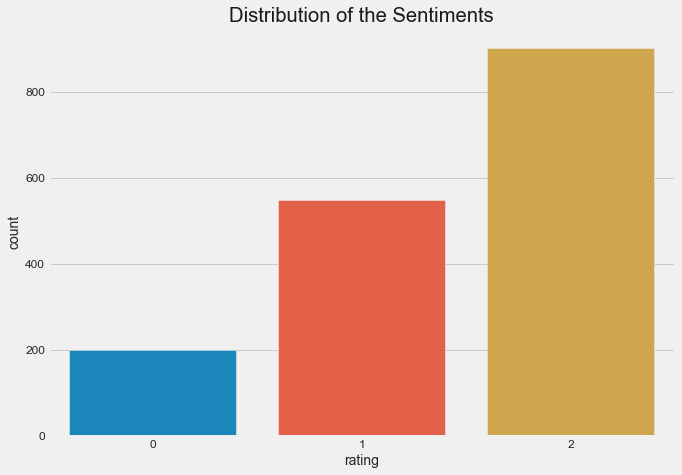

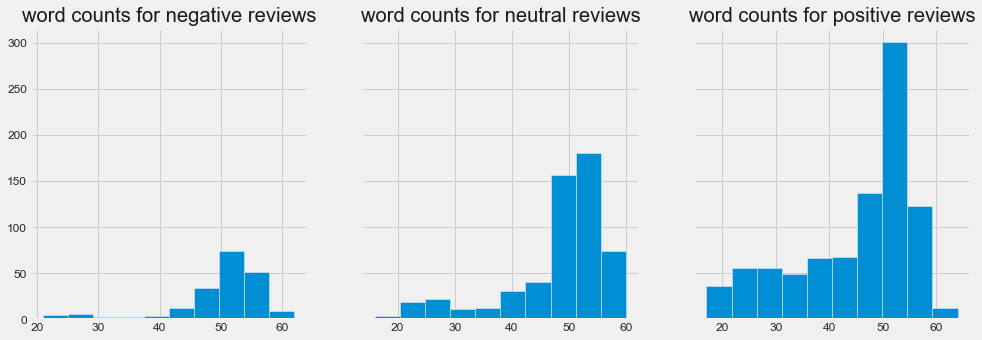

In [287]:
#plotting
sns.countplot(rev['rating'])
plt.title('Distribution of the Sentiments')

fig,axs = plt.subplots(1,3,figsize = (15,5),sharey = True)


rev.loc[rev.rating == 0,:].word_count.hist(ax= axs[0])
axs[0].set_title('word counts for negative reviews')


rev[rev.rating == 1].word_count.hist(ax = axs[1])
axs[1].set_title('word counts for neutral reviews')


rev[rev.rating == 2].word_count.hist(ax = axs[2])
axs[2].set_title('word counts for positive reviews')


plt.show()

## Time dependent Analysis 
<br> 



### Yearly Analysis 
<br> 

1) We first aggregated the data by year and created the following features; the percentage of ratings for each year, the number of reviews for that year, and the average word count for that year 

2) We see that our counts were higher in year 2019 than in 18 and 20 

3) We see that the majority of the reviews were positive for all the years 

4) The highest percentage of negative reviews was in 2020 and the lowest was in 2018 


5) As we visualize the rating counts for the different years, we see the imbalance in our data since we have more 2019 reviews than the other years, we also confirm that our highest negative review counts were in 2020 and 2019


In [319]:
#break up the ratings 
rev_yr = pd.get_dummies(data = rev, columns = ['rating'])
#group by year and get stats 
rev_yr = rev_yr.groupby('year').agg({'rating_0':'sum','rating_1':'sum','rating_2':'sum','word_count':'mean'})
rev_yr.columns= ['rating_0_percent', 'rating_1_percent', 'rating_2_percent', 'word_count_avg']
rev_yr['review_counts'] = rev_yr.iloc[:,0:3].sum(axis = 1)
rev_yr[['rating_0_percent','rating_1_percent','rating_2_percent']] = rev_yr[['rating_0_percent','rating_1_percent','rating_2_percent']].transform(lambda x: x /rev_yr['review_counts'] * 100)

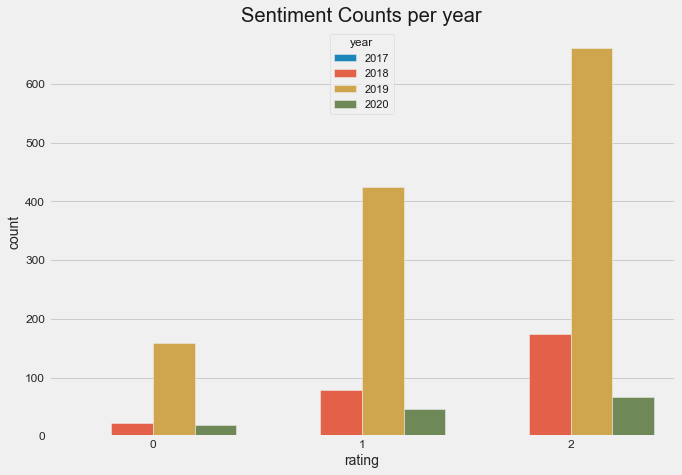



Yearly Statistics:



,rating_0_percent,rating_1_percent,rating_2_percent,word_count_avg,review_counts,revenue
year,,,,,,
2017,0.000000,0.000000,100.000000,52.000000,1.0,NaN
2018,8.029197,28.467153,63.503650,43.817518,274.0,1.372290e+09
2019,12.760835,34.109149,53.130016,47.086677,1246.0,1.398244e+09
2020,14.393939,34.848485,50.757576,46.916667,132.0,1.535610e+08


In [347]:
plt.title('Sentiment Counts per year')
sns.countplot(data = rev, x='rating',hue = 'year')
plt.show()
print('\n')
print('Yearly Statistics:\n')
rev_yr

# Revenue and Review analysis 

<br> 

## Trends 

1) We first investigated how revenue and sentiment interact over time, our scatter plot below showcases that revenue decreased in years with a higher proportion of negative sentiment.


2) Similarly we see a strong correlation between the number of reviews and the revenue for that year; years with more reviews are seemingly ones that generate more revenue 


3) Finally, since our average word count is fairly similar across the years its hard to determine a correlation, this can be further investigated by looking at the reviews based on their sentiment and averaging the word counts from each category 




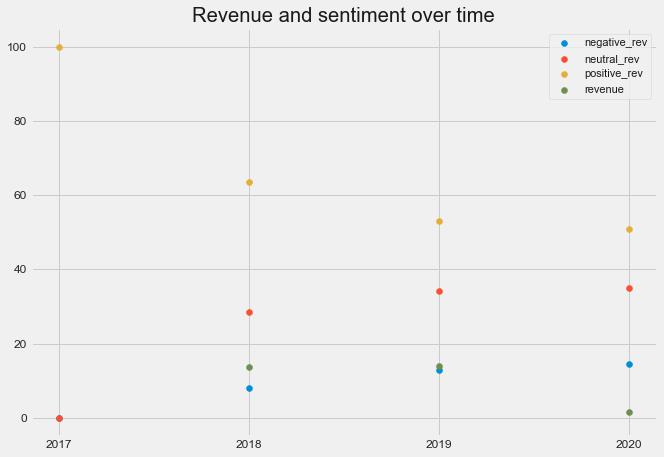

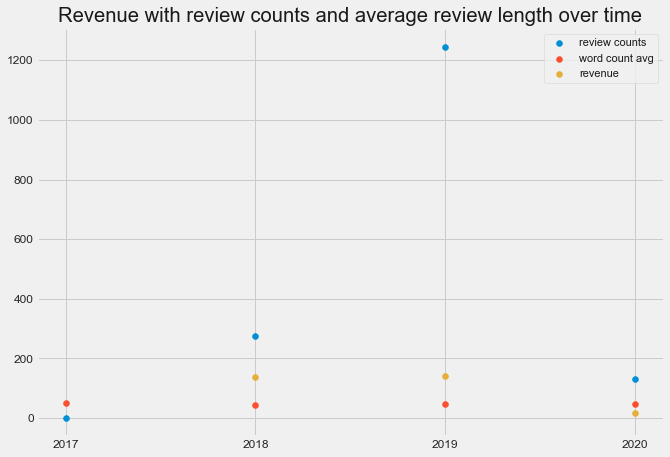

In [379]:
#visualizing revenue and sentiment 
plt.title('Revenue and sentiment over time')
plt.scatter(rev_yr.index,rev_yr['rating_0_percent'])
plt.scatter(rev_yr.index,rev_yr['rating_1_percent'])
plt.scatter(rev_yr.index,rev_yr['rating_2_percent'])
plt.scatter(rev_yr.index,rev_yr['revenue']/1e08)
plt.legend(['negative_rev','neutral_rev','positive_rev','revenue'])

plt.figure()
plt.title('Revenue with review counts and average review length over time')
plt.scatter(rev_yr.index,rev_yr['review_counts'])
plt.scatter(rev_yr.index,rev_yr['word_count_avg'])
plt.scatter(rev_yr.index,rev_yr['revenue']/1e07)

plt.legend(['review counts', 'word count avg', 'revenue'])
plt.show()



In [348]:
#appending revenue

z = revenue.index.tolist()
quarters = [re.sub(r'\d\d\d\d', '',x) for x in z]
years = [re.sub(r'..$', '',x) for x in z]
revenue.index = years
rev_yr['revenue'] = [np.nan, 1.372290e+09,1.398244e+09,1.535610e+08]

## Correlation analysis 

<br> 

Here we used a heat map and a correlation analysis to quantify how our different features effect revenue. Our results were as follows: 


1) Our revenues show strong correlations with our sentiment; We see below that negative or neutral sentiments adversely impact revenues with a -68% correlation factor between negative reviews and revenue, and a -57% correlation with neutral sentiments. This means that an increase in negative or neutral reviews decreases our revenues 


2) We also observe a high positive correlation between revenue and positive reviews with a 62% correlation 



3) Our review counts show a high positive correlation of 61% as well, this is within expectation as the more reviews you have the more visitors you had on average which in turn generates more revenue 


4) Lastly we see a surprising negative correlation between the average word count of the review and the revenue, suggesting that a higher word count in a review decreases the revenue. This is contrary to our earlier analysis and since our data was imbalanced and this feature was not normalized, we can safely ignore this feature for now especially since the correlation factor was low. 

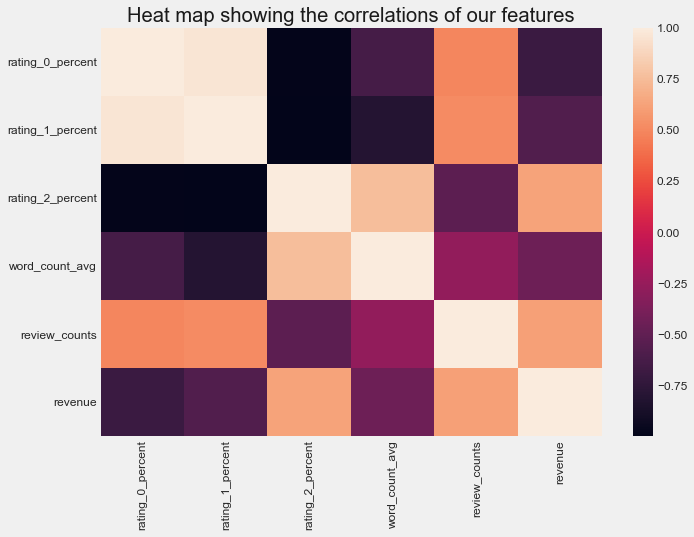



Correlation Statistics:



,rating_0_percent,rating_1_percent,rating_2_percent,word_count_avg,review_counts,revenue
rating_0_percent,1.000000,0.966256,-0.982478,-0.636108,0.497923,-0.685252
rating_1_percent,0.966256,1.000000,-0.997333,-0.806470,0.522735,-0.574063
rating_2_percent,-0.982478,-0.997333,1.000000,0.763761,-0.519309,0.629765
word_count_avg,-0.636108,-0.806470,0.763761,1.000000,-0.265000,-0.443182
review_counts,0.497923,0.522735,-0.519309,-0.265000,1.000000,0.612492
revenue,-0.685252,-0.574063,0.629765,-0.443182,0.612492,1.000000


In [383]:
plt.title('Heat map showing the correlations of our features')
sns.heatmap(rev_yr.corr())
plt.show()

print('\n')
print('Correlation Statistics:\n')
rev_yr.corr()

## Further Correlation analysis 

<br> 

Due to lack of time I was unable to do some things which I believe will increase our confidence in how revenue is impacted by reviews, here are some of them: 


1) Breaking revenues and our analysis into quarterly data (which was my plan). This should give us a more accurate representation of the effects of sentiment and reviews on revenues 


2) Investigating and engineering features such as the average word count, we could have also broken those down into word counts of capital letter comments, comments containing certain words or tokens. This would have allowed us to further investigate what makes a review negative and how many reviews we had for each class of sentiments 


3) Finally with more time one could produce a transfer learning model composed of three stages: 

The first would be a sentiment analysis model where would constantly scrape and model the sentiments on a monthly or quarterly basis 

The second stage would be taking our sentiment scores along with other features (ex: google trends) as well as previous revenues to try and determine how that would effect revenue (increase, decrease, or stay the same) or even a regression analysis with the % change in revenue as our target 



The last stage of the model would be composed of a variety of time series models (like ARIMA) which would take our historic revenue change predictions and provide constantly updating forecasts

# Sentiment modeling: 
<br>

## Noise removal 

Here we cleaned our text data by removing stop words, unusual characters, and  html tags among others 

In [389]:
#importing libraries 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import string

In [390]:
#setting up stop words
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [394]:
def remove_stop(text,stop):
    final_text = []
    for word in word_tokenize(text): 
        if word.strip().lower() not in stop: 
            final_text.append(word.strip())
    return " ".join(final_text)

def remove_paran_brack(text): 
    text = text.replace(')','')
    text = text.replace('(','')
    text = text.replace(']','')
    text = text.replace('[','')
    text = text.replace('\'','')
    return text

def strip_html(text): 
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_html_url(text):
    #url 
    text = re.sub(r'http\S+','',text) 
    return text 

def noise_removal(text,stop): 
    text = remove_stop(text,stop)
    text = remove_paran_brack(text)
    text = remove_html_url(text)
    text = strip_html(text)
    return text 

#updating features 

rev['review'] = rev['review'].apply(lambda x: noise_removal(x,stop))


## Feature engineering: 
<br>
Here we used td-idf vectorizer similar to bag of words but also takes into account frequency of appearance in all documents to create predictive features based on their frequency and context within the document / sentence 

<br>

After transforming our features we end up with 9 predictive features each of which appeared more than 15% of the corpus




In [396]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [398]:
#transoforming 
tf = TfidfVectorizer(strip_accents='ascii', 
                    stop_words='english',token_pattern= r'\w{2,}'
                    ,min_df = 0.15, max_df  = 1.0)
to_transform = rev['review'].values
tf_matrix = tf.fit_transform(to_transform)
tf_matrix = tf_matrix.toarray()
vocab = tf.get_feature_names()
new_df = pd.DataFrame(tf_matrix,columns=vocab)

In [404]:
# new dataset 
data = new_df.join(rev)
data.drop(['quarter','year'],axis = 1,inplace = True)

In [405]:
new_df.shape

(1653, 9)

# Modeling 

## Splitting data training 

Here we split the data into our train and test set and fit our classifier models to predict sentiment 

In [411]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss

In [414]:
x = data.drop(['rating','review'],axis = 1)
y = data.loc[:,'rating']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state =0)

In [415]:
#Fitting and training our classifiers 

#Perceptron 
per = Perceptron(n_jobs= -1)
per.fit(x_train,y_train)

# SGD Linear Classifier 
sgd = SGDClassifier(n_jobs= -1 )
sgd.fit(x_train,y_train)

#SVC classifier 
svc = LinearSVC(random_state= 0)
svc.fit(x_train,y_train)

#Naive Bayes classifier for multinomial models
nb = MultinomialNB(alpha= 0.01)
nb.fit(x_train,y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

## Metric Choices:

Subset accuracy and the Hamming loss were chosen as metrics for the following reasons:


Since our problem is a multi-label classification problem, we must take into account that a prediction which contains a subset of the actual classes is better than one which contains none of them.


The Exact Match Ratio gives us the percentage of matches that have all their labels correctly classified, this has the disadvantage of ignoring partially correct answers, but will be useful as a strict metric of our model's ability to correctly classify all the labels.


To obtain a more accurate view of the performance of our classifier on a label-by-label basis we will also use the Hamming loss which is the fraction of labels that are incorrectly predicted (ie; fraction of wrong labels over total number of labels).

## Predictions and Model Evaluation
Here we predict on the data we held out for validation and use a classification report to check our model's predictive power

For evaluating our model we will use the classification report and the hamming loss 

### Results: 
<br>

Unfortunately due to the small dataset and not having time to use models that take up more computational power like random forest or neural networks, our results weren't satisfactory. 


Our best model was multinomial bayes with a 54% subset accuracy, a 45% hamming loss, and an F1-score of 51% 


As discussed, these were more base models, but the model can easily be extended upon data increase, features from more sources, and more detailed feature engineering. 

In [416]:
#predict
per_pred = per.predict(x_test)
sgd_pred= sgd.predict(x_test)
nb_pred = nb.predict(x_test)
svc_pred = svc.predict(x_test)

In [418]:
# Classification Reports 

models = ['Perceptron','SGD', 'NB', 'LinearSVC']
preds = [per_pred, sgd_pred, nb_pred, svc_pred]

def class_report(models, preds): 

 

    print('Detailed Model Results: \n')
    for pred,model in zip(preds,models):

        print(f"{model} classification report: \n{classification_report(y_test,pred)}")
        print('\n')
        print(f"{model} Subset Accuracy: {accuracy_score(y_test,pred):.3%}\n")
        print(f"{model} Hamming Loss: {hamming_loss(y_test,pred, ):.3%}\n")
        print('\n')
        print('\n')

class_report(models,preds)

Detailed Model Results: 

Perceptron classification report: 
              precision    recall  f1-score   support

           0       0.11      1.00      0.21        57
           1       0.00      0.00      0.00       169
           2       0.00      0.00      0.00       270

    accuracy                           0.11       496
   macro avg       0.04      0.33      0.07       496
weighted avg       0.01      0.11      0.02       496



Perceptron Subset Accuracy: 11.492%

Perceptron Hamming Loss: 88.508%





SGD classification report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.38      0.85      0.53       169
           2       0.73      0.33      0.45       270

    accuracy                           0.47       496
   macro avg       0.37      0.39      0.33       496
weighted avg       0.53      0.47      0.42       496



SGD Subset Accuracy: 46.573%

SGD Hamming Loss: 53.427%





NB classi